# Building environment

## Mount the drive

In [ ]:
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')

Fri Jun 18 07:40:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create the working directory

In [ ]:
import os
WD = '/content/drive/MyDrive/WD'
os.makedirs(WD, exist_ok=True)
os.chdir(WD)

## Setting the kaggle.json

In [ ]:
api_token = {"username":"sandwich72","key":"3dac69b70220026bbeb9ab40ad38e9dd"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

## Download the dataset and unzip

In [ ]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# !unzip chest-xray-pneumonia.zip 
# !mv chest_xray datasets
# !rm chest-xray-pneumonia.zip
# !mkdir checkpoint

# Import packages

In [ ]:
!pip install -q qqdm
import numpy as np
import torch
import torch.nn as nn
from qqdm.notebook import qqdm

# Loading dataset

In [ ]:
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision.datasets import ImageFolder
import gc

def prepare_dataloader():

    first_data = ImageFolder('datasets/train', transform=TRAIN_TFM)
    second_data = ImageFolder('datasets/val', transform=TEST_TFM)
    third_data = ImageFolder('datasets/test', transform=TEST_TFM)

    # Because first_dataset is far larger than the second one, 
    # we split some data from first one to it.
    n_val = int(len(first_data) * VAL_RATIO)
    idx = np.random.permutation(len(first_data))

    train_data = Subset(first_data, idx[n_val:])
    val_data = ConcatDataset([second_data, Subset(first_data, idx[:n_val])])
    test_data = third_data

    print(f'train data: {len(train_data)}')
    print(f'valid data: {len(val_data)}')
    print(f'test data: {len(test_data)}')

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    del first_data, second_data, third_data, train_data, val_data, test_data
    gc.collect()

    return train_loader, val_loader, test_loader

# Setup network

In [ ]:
from torchvision.models.resnet import resnet152
class PneumoniaClassifier(nn.Module):
  
  def __init__(self):
    super(PneumoniaClassifier, self).__init__()

    self.resnet = resnet152(pretrained=True)
    n_feats = self.resnet.fc.in_features
    self.resnet.fc = nn.Sequential(
        nn.Linear(n_feats, 2)
    )

  def forward(self, x):
    return self.resnet(x)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
from torch.optim import Adam, lr_scheduler

def prepare_network(load=False):

    model = PneumoniaClassifier()
    if load:
        model.load_state_dict(torch.load('checkpoint/model.pth'))

    criterion = nn.CrossEntropyLoss()

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    return model, criterion, optimizer, scheduler


# Training & Validation

In [ ]:
def train(model, criterion, optimizer, scheduler, dataloader, phase):

    if phase == "Train":
        model.train()
    elif phase == "Valid":
        model.eval()
    else:
        print("Not exist this mode")
        return

    running_loss = 0.0
    running_correct = 0
    model.to(DEVICE)

    for batch in qqdm(dataloader):

        imgs, labels = batch
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        pred = model(imgs)
        loss = criterion(pred, labels)

        if phase == "Train":
            loss.backward()
            optimizer.step()
            scheduler.step()

        _, result = torch.max(pred, 1)
        running_correct += torch.sum(result == labels.data)
        running_loss += loss.item() * imgs.size(0)
    
    epoch_acc = running_correct / len(dataloader.dataset)
    epoch_loss = running_loss / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()

# Hyperparameters

In [ ]:
from torch.cuda import is_available
from torchvision import transforms

IMG_SIZE = 224
DEVICE = "cuda" if is_available()  else "cpu"

BATCH_SIZE = 32
N_EPOCH = 30
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-5
VAL_RATIO = 0.1
STEP_SIZE = 10
GAMMA = 0.1

TRAIN_TFM = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), inplace=True)
])

TEST_TFM = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Start Training

In [ ]:
train_loader, val_loader, test_loader = prepare_dataloader()
model, criterion, optimizer, scheduler = prepare_network()


train_loss_record = []
train_acc_record = []
valid_loss_record = []
valid_acc_record = []

train data: 4695
valid data: 537
test data: 624


In [ ]:
for epoch in range(N_EPOCH):

    loss, acc = train(model, criterion, optimizer, scheduler, train_loader, "Train")
    train_loss_record.append(loss)
    train_acc_record.append(acc)

    print(f'Train: {epoch+1}/{N_EPOCH} | loss = {loss:.5f}, acc = {acc:.5f}')
    torch.save(model.state_dict(), "checkpoint/model.pth")

    loss, acc = train(model, criterion, optimizer, scheduler, val_loader, "Valid")
    valid_loss_record.append(loss)
    valid_acc_record.append(acc)
    print(f'Valid: {epoch+1}/{N_EPOCH} | loss = {loss:.5f}, acc = {acc:.5f}')


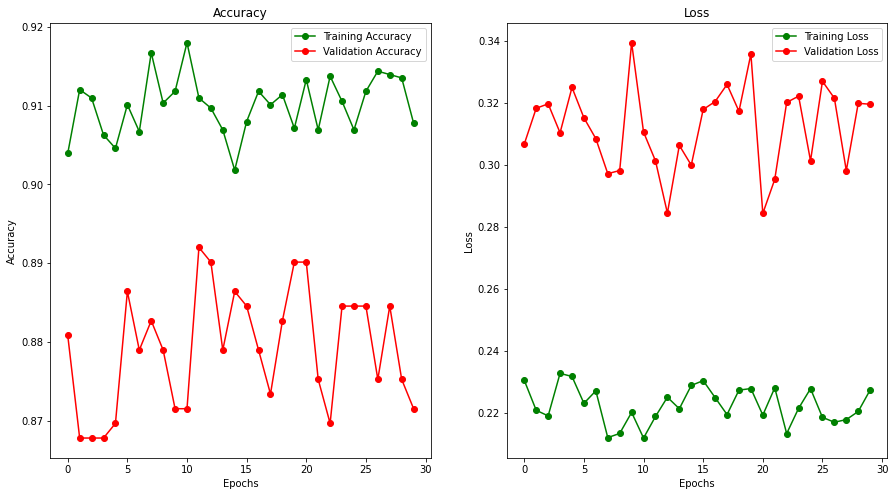

In [ ]:
import matplotlib.pyplot as plt
epochs = [i for i in range(len(train_acc_record))]
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 8)

ax[0].plot(epochs , train_acc_record , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , valid_acc_record , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss_record , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , valid_loss_record , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Testing

In [ ]:
model = PneumoniaClassifier()
model.load_state_dict(torch.load('checkpoint/model.pth'))

loss, acc = train(model, criterion, optimizer, scheduler, test_loader, "Valid")
print(f'Test: loss = {loss:.5f}, acc = {acc:.5f}')

 Iters    Elapsed Time      Speed                                               
 20/20  00:00:14<00:00:00  1.39it/s                                             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Test: loss = 0.72811, acc = 0.72276
